In [1]:
import warnings
import tensorflow as tf
from keras_utils import SGDwithLR,AdamwithClip,RMSpropwithClip
from keras import models
from keras_focused import SimpleFocusedRNN
from keras.optimizers import RMSprop
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing import sequence
from keras import layers
from keras.layers import Flatten,SimpleRNN
import numpy as np
import numpy
from keras import backend as K
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

def lr_settings(all_lr=0.01,sigma_lr=0.01,mu_lr=0.01,mom=0.9,decay_dict_lr=0.1):

  lr_dict = {'all':all_lr,
           'focus-1/Sigma_current:0': sigma_lr,'focus-1/Mu_current:0': mu_lr,'focus-1/kernel:0': all_lr,
           'focus-1/Sigma_prev:0': sigma_lr,'focus-1/Mu_prev:0': mu_lr,'focus-1/recurrent_kernel:0': all_lr,
           'dense-3/Weights:0':all_lr}
        
  #lr_dict = {'all':0.0001}

  mom_dict = {'all':mom}
  #decay_dict = {'all':0.9}
  #mom_dict = {'all':0.9,'focus-1/Sigma:0': 0.25,'focus-1/Mu:0': 0.25,
  #           'focus-2/Sigma:0': 0.25,'focus-2/Mu:0': 0.25}
    
  decay_dict = {'all':all_lr, 'focus-1/Sigma_current:0': decay_dict_lr,'focus-1/Mu_current:0':decay_dict_lr,'focus-1/Sigma_prev:0': decay_dict_lr,'focus-1/Mu_prev:0': decay_dict_lr}

              #'focus-2/Sigma_current:0': 0.1,'focus-2/Mu_current:0': 0.1,'focus-2/Sigma_prev:0': 0.1,'focus-2/Mu_prev:0': 0.1}

  clip_dict = {'focus-1/Sigma_current:0':(0.01,1.0),'focus-1/Mu_current:0':(0.0,1.0),'focus-1/Sigma_prev:0':(0.01,1.0),'focus-1/Mu_prev:0':(0.0,1.0)}

             #'focus-2/Sigma_current:0':(0.05,1.0),'focus-2/Mu_current:0':(0.0,1.0),'focus-2/Sigma_prev:0':(0.05,1.0),'focus-2/Mu_prev:0':(0.0,1.0)}
  return lr_dict,mom_dict,decay_dict,clip_dict

The name for Record Variable has changed, use RecordWeights or RecordTensor instead
Not working!


Using TensorFlow backend.


In [0]:
from keras.callbacks import Callback
class PrintLayerVariableStats(Callback):
    def __init__(self,name,var,stat_functions,stat_names,num):
        self.layername = name
        self.varname = var
        self.stat_list = stat_functions
        self.stat_names = stat_names
        self.num=num

    def setVariableName(self,name, var):
        self.layername = name
        self.varname = var
    def on_train_begin(self, logs={}):
        all_params = self.model.get_layer(self.layername)._trainable_weights
        all_weights = self.model.get_layer(self.layername).get_weights()
        #print("self.model",self.model)
        #print("all_params",all_params)
        #print("self.layername",self.layername)
        #print("self.varname",self.varname)
        i=self.num
        if(i == 0):
            stat_str = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("\nStats for kernel:0 ", stat_str)
        if(i == 1):
            stat_str_1 = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("Stats for Sigma_current:0 ", stat_str_1)
        if(i == 2):
            stat_str_2 = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("Stats for Mu_current:0 ", stat_str_2)
        if(i == 3):
            stat_str_3 = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("Stats for recurrent_kernel:0 ", stat_str_3)
        
        
        

        #def on_batch_end(self, batch, logs={}):
        #    self.record.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        all_weights = self.model.get_layer(self.layername).get_weights()
        i=self.num
        if(i == 0):
            stat_str = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("\nStats for kernel:0 ", stat_str)
        if(i == 1):
            stat_str_1 = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("Stats for Sigma_current:0 ", stat_str_1)
        if(i == 2):
            stat_str_2 = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("Stats for Mu_current:0 ", stat_str_2)
        if(i == 3):
            stat_str_3 = [n+str(s(all_weights[i])) for s,n in zip(self.stat_list,self.stat_names)]
            print("Stats for recurrent_kernel:0 ", stat_str_3)

In [0]:
from keras.optimizers import SGD
def build_model(N=64,mod='dense', optimizer_s='SGDwithLR',dropout=0.2, recurrent_dropout=0.2, init_sigma_current= 0.1, init_sigma_prev=0.1,num_epochs=15,sgd_settings=None,dataset_percantage=100,
                initer=None,distribution=None):
    top_words = 5000
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
    # truncate and pad input sequences
    max_review_length = 500
    if dataset_percantage == 100:
      print("100")
      X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
      X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
    elif dataset_percantage == 75:
      X_train = sequence.pad_sequences(X_train[0:18750], maxlen=max_review_length)
      X_test = sequence.pad_sequences(X_test[0:18750], maxlen=max_review_length)
      y_train = y_train[0:18750]
      y_test = y_test[0:18750]
      print("75")
    elif dataset_percantage == 50:
      X_train = sequence.pad_sequences(X_train[0:12500], maxlen=max_review_length)
      X_test = sequence.pad_sequences(X_test[0:12500], maxlen=max_review_length)
      y_train = y_train[0:12500]
      y_test = y_test[0:12500]
    elif dataset_percantage == 25:
      X_train = sequence.pad_sequences(X_train[0:6250], maxlen=max_review_length)
      X_test = sequence.pad_sequences(X_test[0:6250], maxlen=max_review_length)
      y_train = y_train[0:6250]
      y_test = y_test[0:6250]
    elif dataset_percantage == 10:
      X_train = sequence.pad_sequences(X_train[0:2500], maxlen=max_review_length)
      X_test = sequence.pad_sequences(X_test[0:2500], maxlen=max_review_length)
      y_train = y_train[0:2500]
      y_test = y_test[0:2500]
    embedding_vecor_length = 32
    model = Sequential()
    model.add(layers.Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
    #model.add(Flatten())
    if mod=='simplernn':
        model.add(SimpleRNN(100))
    elif mod=='focused':
        model.add(SimpleFocusedRNN(units=N,
                                  name='focus-1',
                                  kernel_initializer='he_normal',
                                  dropout=dropout,
                                  recurrent_dropout=recurrent_dropout,
                                  init_sigma_current=init_sigma_current,
                                  init_sigma_prev=init_sigma_prev,
                                   initer=initer,
                                   distribution=distribution))
               
            
    model.add(layers.Dense(1,name='dense-3',activation='sigmoid'))
    

    if optimizer_s == 'SGDwithLR' and sgd_settings != None:
        decay_epochs =[3,5,8,11]      
        opt = SGDwithLR(lr=sgd_settings[0], momentum=sgd_settings[1],decay=sgd_settings[2],clips=sgd_settings[3],decay_epochs=decay_epochs,verbose=1)#, decay=None)
    elif optimizer_s == 'AdamwithClip':
        opt=AdamwithClip()
    elif optimizer_s=='RMSpropwithClip':
        opt = RMSpropwithClip(lr=0.001, rho=0.9, epsilon=None, decay=0.0,clips=clip_dict)
    elif optimizer_s == 'adam':
        opt='adam'
    else:
        opt= SGD(lr=0.01, momentum=0.9)#, decay=None)
    print("opt= ",opt)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    stat_func_name = ['max: ', 'mean: ', 'min: ', 'var: ', 'std: ']
    stat_func_list = [np.max, np.mean, np.min, np.var, np.std]
    callbacks = []
    pr_0 = PrintLayerVariableStats("focus-1","kernel:0",stat_func_list,stat_func_name,0)
    pr_1 = PrintLayerVariableStats("focus-1","Sigma_current:0",stat_func_list,stat_func_name,1)
    pr_2 = PrintLayerVariableStats("focus-1","Mu_current:0",stat_func_list,stat_func_name,2)
    pr_3 = PrintLayerVariableStats("focus-1","recurrent_kernel:0",stat_func_list,stat_func_name,3)
    callbacks+=[pr_0,pr_1,pr_2,pr_3]


    print(model.summary())
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=64,verbose=1,callbacks=callbacks)
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return history

{'all': 0.015, 'focus-1/Sigma_current:0': 0.015, 'focus-1/Mu_current:0': 0.015, 'focus-1/kernel:0': 0.015, 'focus-1/Sigma_prev:0': 0.015, 'focus-1/Mu_prev:0': 0.015, 'focus-1/recurrent_kernel:0': 0.015, 'dense-3/Weights:0': 0.015}
100
input_shape (None, 32)
self.input_dim=  32
initilizer=  Glorot
distribution uniform
u_current Tensor("focus-1/transpose_2:0", shape=(32, 100), dtype=float32)
u_previous Tensor("focus-1/transpose_3:0", shape=(100, 100), dtype=float32)
u_current Tensor("focus-1/while/transpose:0", shape=(32, 100), dtype=float32)
u_previous Tensor("focus-1/while/transpose_1:0", shape=(100, 100), dtype=float32)
opt=  <keras_utils.AdamwithClip object at 0x7fecf85cae10>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
focus-1 (SimpleFocusedRNN) 

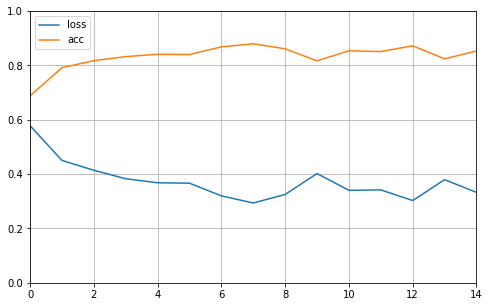

In [6]:
dataset_percantage=100  #use dataset %10,%25,%50,%75
K.clear_session()
mod='focused'
N=100
all_lr=0.015
sigma_lr=0.015
mu_lr=0.015
mom=0.9
decay_dict_lr=0.1
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
sgd_settings=lr_settings(all_lr=all_lr,sigma_lr=sigma_lr,mu_lr=mu_lr,mom=mom,decay_dict_lr=decay_dict_lr)
print(sgd_settings[0])
history_glorot_uniform = build_model(N,mod,optimizer_s='AdamwithClip',num_epochs=15,sgd_settings=None,dataset_percantage=dataset_percantage,initer='Glorot',distribution='uniform')#glorot uniform

pd.DataFrame(history_glorot_uniform.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

{'all': 0.015, 'focus-1/Sigma_current:0': 0.015, 'focus-1/Mu_current:0': 0.015, 'focus-1/kernel:0': 0.015, 'focus-1/Sigma_prev:0': 0.015, 'focus-1/Mu_prev:0': 0.015, 'focus-1/recurrent_kernel:0': 0.015, 'dense-3/Weights:0': 0.015}
100
input_shape (None, 32)
self.input_dim=  32
initilizer=  He
distribution uniform
u_current Tensor("focus-1/transpose_2:0", shape=(32, 100), dtype=float32)
u_previous Tensor("focus-1/transpose_3:0", shape=(100, 100), dtype=float32)
u_current Tensor("focus-1/while/transpose:0", shape=(32, 100), dtype=float32)
u_previous Tensor("focus-1/while/transpose_1:0", shape=(100, 100), dtype=float32)
opt=  <keras_utils.AdamwithClip object at 0x7fecf89412e8>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
focus-1 (SimpleFocusedRNN)   (N

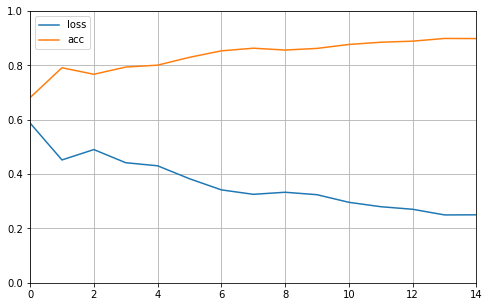

In [5]:
dataset_percantage=100  #use dataset %10,%25,%50,%75
K.clear_session()
mod='focused'
N=100
all_lr=0.015
sigma_lr=0.015
mu_lr=0.015
mom=0.9
decay_dict_lr=0.1
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
sgd_settings=lr_settings(all_lr=all_lr,sigma_lr=sigma_lr,mu_lr=mu_lr,mom=mom,decay_dict_lr=decay_dict_lr)
print(sgd_settings[0])
history_he_uniform = build_model(N,mod,optimizer_s='AdamwithClip',num_epochs=15,sgd_settings=None,dataset_percantage=dataset_percantage,initer='He',distribution='uniform')#he uniform

pd.DataFrame(history_he_uniform.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()




{'all': 0.015, 'focus-1/Sigma_current:0': 0.015, 'focus-1/Mu_current:0': 0.015, 'focus-1/kernel:0': 0.015, 'focus-1/Sigma_prev:0': 0.015, 'focus-1/Mu_prev:0': 0.015, 'focus-1/recurrent_kernel:0': 0.015, 'dense-3/Weights:0': 0.015}
17465344/17464789 [==============================] - 1s 0us/step
100


input_shape (None, 32)
self.input_dim=  32
initilizer=  He
distribution normal






u_current Tensor("focus-1/transpose_2:0", shape=(32, 100), dtype=float32)
u_previous Tensor("focus-1/transpose_3:0", shape=(100, 100), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
u_current Tensor("focus-1/while/transpose:0", shape=(32, 100), dtype=float32)
u_previous Tensor("focus-1/while/transpose_1:0", shape=(100, 100), dtype=float32)
opt=  <keras_utils.AdamwithClip object at 0x7feceee13c88>


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________

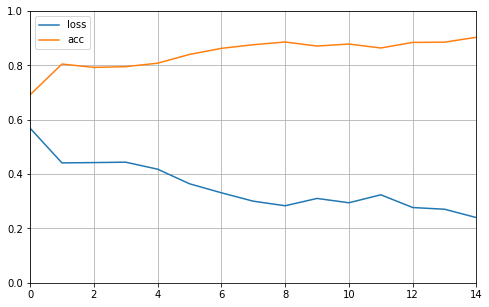

In [4]:
dataset_percantage=100  #use dataset %10,%25,%50,%75
K.clear_session()
mod='focused'
N=100
all_lr=0.015
sigma_lr=0.015
mu_lr=0.015
mom=0.9
decay_dict_lr=0.1
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
sgd_settings=lr_settings(all_lr=all_lr,sigma_lr=sigma_lr,mu_lr=mu_lr,mom=mom,decay_dict_lr=decay_dict_lr)
print(sgd_settings[0])
history_he_normal = build_model(N,mod,optimizer_s='AdamwithClip',num_epochs=15,sgd_settings=None,dataset_percantage=dataset_percantage,initer='He',distribution='normal')#he normal
pd.DataFrame(history_he_normal.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()